In [1]:
from tensorflow import keras

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.activations import *

import tensorflow as tf
import cv2
import random
import matplotlib.pylab as plt
%matplotlib inline

In [2]:
import numpy as np
import glob
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10

In [3]:
#import tensorflow

tf.__version__

'2.1.0'

In [4]:
def layer1(input_, filters=64):
    c1 = Conv2D(filters=filters, kernel_size=(3,3), strides=(1, 1), activation='relu', padding='same')(input_)
    bn1 = BatchNormalization()(c1)
    actRelu = relu(bn1)
    
    return actRelu

def layer2(input_, filters=64):
    l1 = layer1(input_)
    c1 = Conv2D(filters=filters, kernel_size=(3,3), strides=(1, 1), activation='relu', padding='same')(l1)
    bn1 = BatchNormalization()(c1)
    conc = concatenate([bn1, input_])
    
    return conc

def layer3(input_, filters=64):
    l1 = layer1(input_)
    c1 = Conv2D(filters=filters, kernel_size=(3,3), strides=(1, 1), activation='relu', padding='same')(l1)
    bn1 = BatchNormalization()(c1)
    mp1 = MaxPool2D(pool_size=(2,2), strides=(2, 2))(bn1)
    
    # side stream
    c1_s = Conv2D(filters=filters, kernel_size=(1,1), strides=(2, 2), activation='relu', padding='same')(input_)
    bn1_s = BatchNormalization()(c1_s)
    
    conc = concatenate([mp1, bn1_s])
    
    return conc

def layer4(input_, filters=64):
    l1 = layer1(input_)
    c1 = Conv2D(filters=filters, kernel_size=(3,3), strides=(1, 1), activation='relu', padding='same')(l1)
    bn1 = BatchNormalization()(c1)
    g1 = GlobalAveragePooling2D()(bn1)
    
    return g1

In [5]:
def srnet(input_img):
    # Two layers of type 1
    l1_1 = layer1(input_img, filters=64)
    l1_2 = layer1(l1_1, filters=16)
    
#     # Five layers of type 2
    l2_1 = layer2(l1_2, filters=16)
    l2_2 = layer2(l2_1, filters=16)
    l2_3 = layer2(l2_2, filters=16)
    l2_4 = layer2(l2_3, filters=16)
    l2_5 = layer2(l2_4, filters=16)
    
    l3_1 = layer3(l2_5, filters=16)
    l3_2 = layer3(l3_1, filters=64)
    
    l4_1 = layer4(l3_2, filters=16)
    
    fc1 = Flatten()(l4_1)
    d1 = Dense(512)(fc1)
    
#     a1 = softmax(d1)
    
    return d1

In [6]:
image_size = (32, 32)
input_img = Input(shape = (*image_size, 3))

model_BGR =  Sequential(Model(input_img, srnet(input_img)))


model_HSV = Sequential(Model(input_img, srnet(input_img)))
# model_HSV.add(Flatten())


# # model_YUV = Model(input_img, model(input_img))
model_YUV = Sequential(Model(input_img, srnet(input_img)))
# model_YUV.add(Flatten())

# # model_LAB = Model(input_img, model(input_img))
model_LAB = Sequential(Model(input_img, srnet(input_img)))
# model_LAB.add(Flatten())

model_HED = Sequential(Model(input_img, srnet(input_img)))
# model_HED.add(Flatten())

model_XYZ = Sequential(Model(input_img, srnet(input_img)))
# model_XYZ.add(Flatten())

In [7]:
x = concatenate(inputs=[model_BGR.output, model_HSV.output, model_YUV.output,
                       model_LAB.output, model_HED.output, model_XYZ.output])

In [8]:
z = Dense(2, activation="softmax")(x)
# our model will accept the inputs of the two branches and
# then output a single value
model_comb = Model(inputs=[model_BGR.input, model_HSV.input, model_YUV.input, 
                          model_LAB.input, model_HED.input, model_XYZ.input], outputs=z)

In [9]:
model_comb.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
model_input (InputLayer)        [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
model_1_input (InputLayer)      [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
model_2_input (InputLayer)      [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
model_3_input (InputLayer)      [(None, 32, 32, 3)]  0                                            
____________________________________________________________________________________________

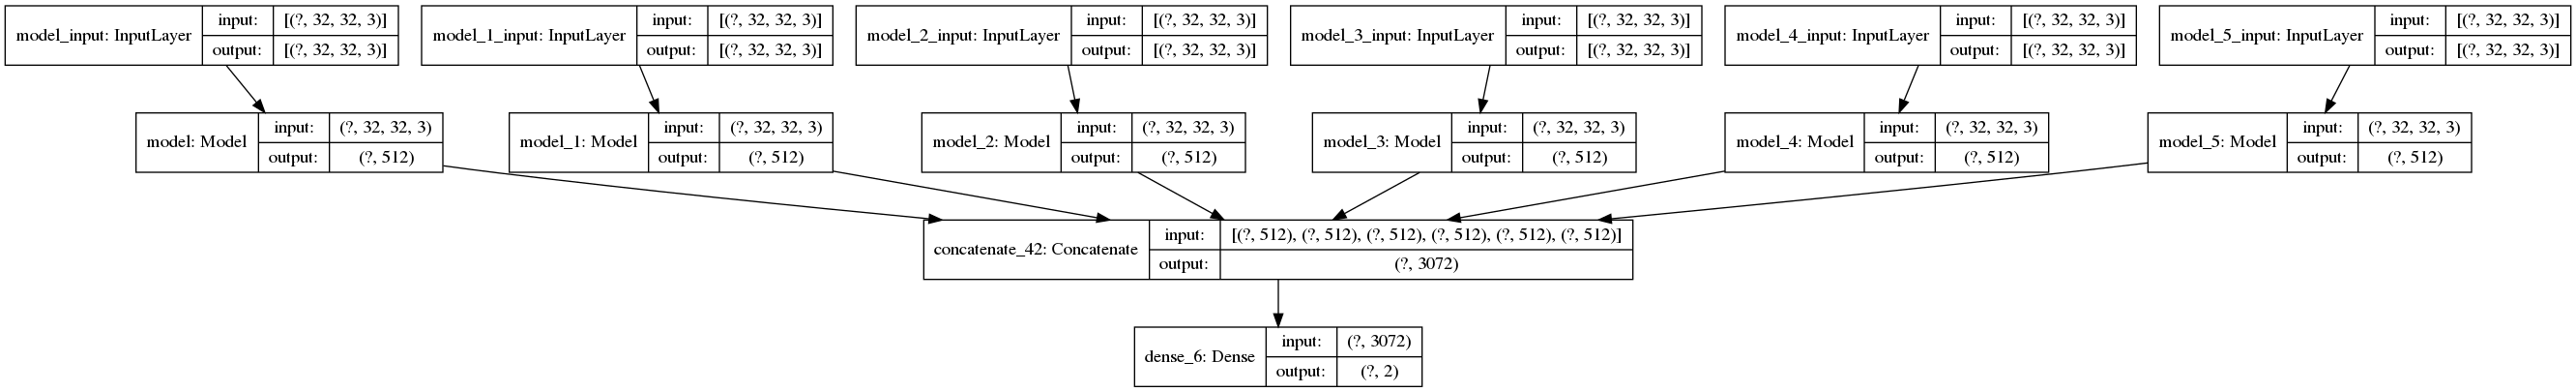

In [14]:
tf.keras.utils.plot_model(model_comb, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
from skimage.color import rgb2hed

In [ ]:
img = cv2.imread('../Cover/00010.jpg')#, cv2.COLOR_BGR2RGB)

In [ ]:
def changeColorSpace(img, flag):
    if flag == 'flag_HED':
        img = rgb2hed(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        return img/np.max(img)
    else:
        img = cv2.cvtColor(img, flag)
        return img/np.max(img)

In [ ]:
flag_HSV = cv2.COLOR_BGR2HSV
flag_YUV = cv2.COLOR_BGR2YUV
flag_LAB = cv2.COLOR_BGR2LAB
flag_HED = 'flag_HED'
flag_XYZ = cv2.COLOR_BGR2XYZ

In [ ]:
img_hed = changeColorSpace(img, flag_HSV)

fig, axes = plt.subplots(2, 2, figsize=(7, 6))
ax0, ax1, ax2, ax3 = axes.ravel()

ax0.imshow(img)
ax0.set_title("Original image")

ax1.imshow(img_hed[:, :, 0], cmap=plt.cm.gray)

ax2.imshow(img_hed[:, :, 1], cmap=plt.cm.gray)
#ax2.set_title("Eosin")

ax3.imshow(img_hed[:, :, 2], cmap=plt.cm.gray)
#ax3.set_title("DAB")

for ax in axes.ravel():
    ax.axis('off')

fig.subplots_adjust(hspace=0.3)

In [ ]:
img_hed = changeColorSpace(img, flag_YUV)

fig, axes = plt.subplots(2, 2, figsize=(7, 6))
ax0, ax1, ax2, ax3 = axes.ravel()

ax0.imshow(img)
ax0.set_title("Original image")

ax1.imshow(img_hed[:, :, 0], cmap=plt.cm.gray)

ax2.imshow(img_hed[:, :, 1], cmap=plt.cm.gray)
#ax2.set_title("Eosin")

ax3.imshow(img_hed[:, :, 2], cmap=plt.cm.gray)
#ax3.set_title("DAB")

for ax in axes.ravel():
    ax.axis('off')

fig.subplots_adjust(hspace=0.3)

In [ ]:
img_hed = changeColorSpace(img, flag_LAB)

fig, axes = plt.subplots(2, 2, figsize=(7, 6))
ax0, ax1, ax2, ax3 = axes.ravel()

ax0.imshow(img)
ax0.set_title("Original image")

ax1.imshow(img_hed[:, :, 0], cmap=plt.cm.gray)

ax2.imshow(img_hed[:, :, 1], cmap=plt.cm.gray)
#ax2.set_title("Eosin")

ax3.imshow(img_hed[:, :, 2], cmap=plt.cm.gray)
#ax3.set_title("DAB")

for ax in axes.ravel():
    ax.axis('off')

fig.subplots_adjust(hspace=0.3)

In [ ]:
img_hed = changeColorSpace(img, flag_HED)

fig, axes = plt.subplots(2, 2, figsize=(7, 6))
ax0, ax1, ax2, ax3 = axes.ravel()

ax0.imshow(img)
ax0.set_title("Original image")

ax1.imshow(img_hed[:, :, 0], cmap=plt.cm.gray)

ax2.imshow(img_hed[:, :, 1], cmap=plt.cm.gray)
#ax2.set_title("Eosin")

ax3.imshow(img_hed[:, :, 2], cmap=plt.cm.gray)
#ax3.set_title("DAB")

for ax in axes.ravel():
    ax.axis('off')

fig.subplots_adjust(hspace=0.3)

In [ ]:
img_hed = changeColorSpace(img, flag_XYZ)

fig, axes = plt.subplots(2, 2, figsize=(7, 6))
ax0, ax1, ax2, ax3 = axes.ravel()

ax0.imshow(img)
ax0.set_title("Original image")

ax1.imshow(img_hed[:, :, 0], cmap=plt.cm.gray)

ax2.imshow(img_hed[:, :, 1], cmap=plt.cm.gray)
#ax2.set_title("Eosin")

ax3.imshow(img_hed[:, :, 2], cmap=plt.cm.gray)
#ax3.set_title("DAB")

for ax in axes.ravel():
    ax.axis('off')

fig.subplots_adjust(hspace=0.3)

In [ ]:
def get_image_data(image_id, image_size):
    img = cv2.imread(image_id)
    h, w = image_size
    crop_img = img[0:h, 0:w]
    return crop_img//1

def get_label(image_id):
    if 'Cover' in image_id:
        return [1,0]
    else:
        return [0,1]

In [ ]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, batch_size=32, dim=(32,32,32), n_channels=1, 
                 shuffle=True, number_of_labels=2, flag=None):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()
        self.number_of_labels = number_of_labels
        self.flag = flag
        
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))
    
    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        
        """Getting items from the 2 generators and packing them"""
#         img = get_image_data(list_IDs_temp[0], self.dim)
        
#         X1, X2, X3, X4, X5, X6 = [img/np.max(img), changeColorSpace(img, flag_HSV), 
#                                   changeColorSpace(img, flag_YUV), changeColorSpace(img, flag_LAB), 
#                                   changeColorSpace(img, flag_HED), changeColorSpace(img, flag_XYZ)]
        
#         X_batch = ([np.array(X1), np.array(X2), np.array(X3), np.array(X4), np.array(X5), np.array(6)])
#         y_batch = ([np.array(get_label(list_IDs_temp[0]))])
        
#         img = get_image_data(list_IDs_temp[1], self.dim)
        
#         X1, X2, X3, X4, X5, X6 = [img/np.max(img), changeColorSpace(img, flag_HSV), 
#                                   changeColorSpace(img, flag_YUV), changeColorSpace(img, flag_LAB), 
#                                   changeColorSpace(img, flag_HED), changeColorSpace(img, flag_XYZ)]
        
#         X_batch.append([X1, X2, X3, X4, X5, X6])
#         y_batch.append(get_label(list_IDs_temp[1]))

#         return X_batch, y_batch

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)
        # cv2 recevrses height and width
        return [X[0], X[1], X[2], X[3], X[4], X[5]], y
#         return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
#         X = np.empty((self.batch_size, *self.dim[::-1], self.n_channels))
#         y = np.empty((self.batch_size, *self.dim[::-1]))
        X = np.empty((6, self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, self.number_of_labels))
        
        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            img = get_image_data(ID, self.dim)
            X[0,i] = img/np.max(img)
            X[1,i] = changeColorSpace(img, flag_HSV)
            X[2,i] = changeColorSpace(img, flag_YUV)
            X[3,i] = changeColorSpace(img, flag_LAB)
            X[4,i] = changeColorSpace(img, flag_HED)
            X[5,i] = changeColorSpace(img, flag_XYZ)
            
            y[i,:] = get_label(ID)
                    
        return X, y

In [ ]:
limit = 250
cover_imgs = glob.glob('../Cover/*.jpg')
cover_imgs = cover_imgs[:limit]

jmipod_imgs = glob.glob('../JMiPOD/*.jpg')
jmipod_imgs = jmipod_imgs[:limit]

juniward_imgs = glob.glob('../JUNIWARD/*.jpg')
juniward_imgs = juniward_imgs[:limit]

uerd_imgs = glob.glob('../UERD/*.jpg')
uerd_imgs = uerd_imgs[:limit]

list_IDs = cover_imgs + jmipod_imgs + juniward_imgs + uerd_imgs

random.Random(4).shuffle(list_IDs)

train_IDs = list_IDs[:750]
test_IDs = list_IDs[750:]

In [ ]:
params = {'dim': image_size,
          'batch_size': 1,
          'n_channels': 3,
          'shuffle': True, }

# Generators
training_generator = DataGenerator(train_IDs, **params)

In [ ]:
X,y = training_generator.__getitem__(0)

In [ ]:
len(X)

In [ ]:
X[0].shape

In [ ]:
plt.imshow(X[0][0])

In [ ]:
model_comb.compile(loss=keras.losses.binary_crossentropy, 
                    metrics=['accuracy'], optimizer='adadelta')

In [ ]:
model_comb.fit_generator(generator=training_generator, epochs=5)

In [ ]:
len(X)